# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

In [ ]:
# Check TF versions and CPU/GPU availability
print(tf.__version__)
print(tf.config.list_physical_devices())
print(tf.test.is_gpu_available)
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.20.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
<function is_gpu_available at 0x74172c348860>
True
True
Num CPUs Available:  1
Num GPUs Available:  0


2026-02-24 11:18:04.560494: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd
!ls

/content
drive  sample_data


In [6]:
import os
os.chdir("/content/drive/My Drive/Untrained-PINN-for-SIM-main")
print(os.getcwd())

/content/drive/My Drive/Untrained-PINN-for-SIM-main


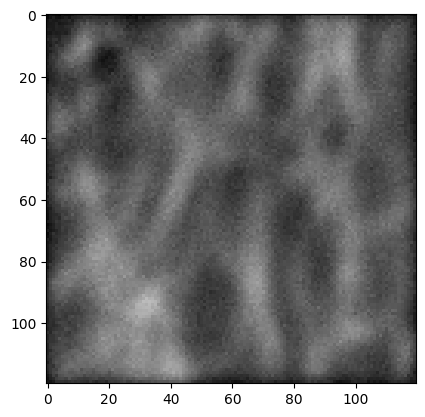

In [7]:
import cv2 #show first picture of folder as image in notebook
img = cv2.imread('Data/LPSIM/microtubules/input_frames/1_1.png')
plt.imshow(img)

## Model Choice

A basic CNN was chosen as baseline model, based on the publication notebook PINN_demo_plasmonic_SIM


## Implementation





In [8]:
import numpy as np
import cv2

num_im = 50      # Number of examples in dataset
frames = 24       # Number of sub-frames per example
im_dim = 480     # Image dimension (after super-res)
bg_lvl = 0       # Optional bg level subtraction

input_frames = np.zeros([num_im,im_dim,im_dim,frames])
gt_frames = np.zeros([num_im,im_dim,im_dim,1])
lr_frames = np.zeros([num_im,im_dim,im_dim,1])
patterns = np.zeros([frames,im_dim,im_dim,1])


## Load Data

In [9]:
data_name = 'microtubules'
dir_name = 'Data/LPSIM/'

for i in range(1,num_im):
      
    for j in range(1,(frames+1)):
       
        input_path = dir_name+data_name+'/input_frames/'+str(i)+'_'+str(j)+'.png'
        input_temp = cv2.imread(input_path,0)
        input_temp = cv2.resize(input_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
        input_frames[i-1,:,:,j-1] = input_temp                  
    
    gt_path = dir_name+data_name+'/ground_truth/'+str(i)+'.png'
    gt_temp = cv2.imread(gt_path,0)
    gt_temp = cv2.resize(gt_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    gt_temp = gt_temp.reshape([im_dim,im_dim,1])
    gt_frames[i-1,:,:,:] = gt_temp

    lr_path = dir_name+data_name+'/low_res/'+str(i)+'.png'
    lr_temp = cv2.imread(lr_path,0)
    lr_temp = cv2.resize(lr_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)
    lr_temp = lr_temp.reshape([im_dim,im_dim,1])
    lr_frames[i-1,:,:,:] = lr_temp
    

for i in range(1,(frames+1)):
    
    pattern_path = dir_name+data_name+'/patterns/'+str(i)+'.png'
    pattern_temp = cv2.imread(pattern_path,0)
    pattern = cv2.resize(pattern_temp,dsize=(im_dim,im_dim), interpolation=cv2.INTER_CUBIC)  
    pattern = pattern.reshape([im_dim,im_dim,1])
    patterns[i-1,:,:,:] = pattern
            

## Check and Normalize Data

In [10]:
print(np.amax(input_frames))
input_frames = input_frames - bg_lvl;
input_frames[input_frames<0] = 0
input_frames = input_frames/np.amax(input_frames)
print(np.amax(input_frames))
gt_fames = gt_frames/np.amax(gt_frames)
lr_frames = lr_frames/np.amax(lr_frames)
patterns = patterns/np.amax(patterns)
print(input_frames.shape)
print(gt_frames.shape)

255.0
1.0
(50, 480, 480, 24)
(50, 480, 480, 1)


Text(0.5, 1.0, 'Illumination pattern')

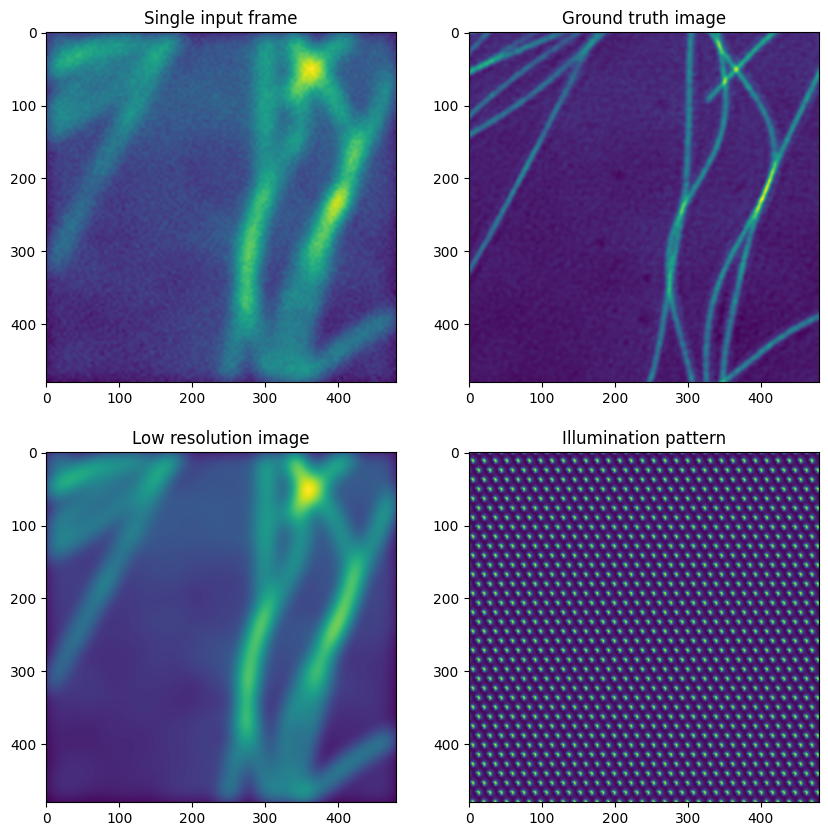

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(input_frames[1,:,:,1])
plt.title('Single input frame')
plt.subplot(2,2,2)
plt.imshow(gt_frames[1,:,:,:])
plt.title('Ground truth image')
plt.subplot(2,2,3)
plt.imshow(lr_frames[1,:,:,:])
plt.title('Low resolution image')
plt.subplot(2,2,4)
plt.imshow(patterns[1,:,:,:])
plt.title('Illumination pattern')

## Define Model

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D
from tensorflow.keras.models import Model

def baseline_model():
    # Input layer with shape (im_dim, im_dim, 1) for low-resolution images
    inputs = Input(shape=(im_dim, im_dim, 1))

    # Encoder part / feature extraction layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# No upsampling layers were added for simplicity reasons

    # Decoder part / reconstruction layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer: 1 filter for a single channel output image
    # Using 'relu' to keep pixel values non-negative and capped at 1.0 due to previous normalization
    outputs = Conv2D(1, (3, 3), activation='relu', padding='same')(x)


    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the baseline model
baseline_cnn_model = baseline_model()

# Print the model summary
print("Baseline CNN Model Architecture:")
baseline_cnn_model.summary()


Baseline CNN Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 480, 480, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 480, 480, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 480, 480, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 480, 480, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 480, 480, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 480, 480, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
learning_rate = 0.001 

# Define the loss function and optimizer

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=50,
    decay_rate=0.90,
    staircase=True)

opt_baseline = tf.keras.optimizers.Adam(lr_schedule)

# Changed x_baseline to use lr_frames which has 1 channel
x_baseline= np.reshape(lr_frames,[num_im,im_dim,im_dim,1])
y_baseline= np.reshape(gt_frames,[num_im,im_dim,im_dim,1])


# Compile and train the baseline model

mse_loss = tf.keras.losses.MeanSquaredError()

eps = 10

baseline_cnn_model.compile(loss=mse_loss, optimizer=opt_baseline)

print("Baseline CNN model compiled.")

Baseline CNN model compiled.


In [14]:
batch_size = 1 

baseline_model_history = baseline_cnn_model.fit(
    x_baseline,
    y_baseline,
    batch_size=batch_size,
    epochs=eps,
    shuffle=True
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - loss: 2094.2415
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - loss: 548.5421
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - loss: 535.1504
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - loss: 512.1560
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - loss: 493.7014
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 259s 5s/step - loss: 538.5184
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - loss: 516.1799
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - loss: 473.2473
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - loss: 498.9126
Epoch 10/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - loss: 486.1331


In [15]:
#print last epoch MSE loss
final_loss = baseline_model_history.history['loss'][-1]
print(f"Final epoch MSE loss: {final_loss}")


Final epoch MSE loss: 505.9163818359375


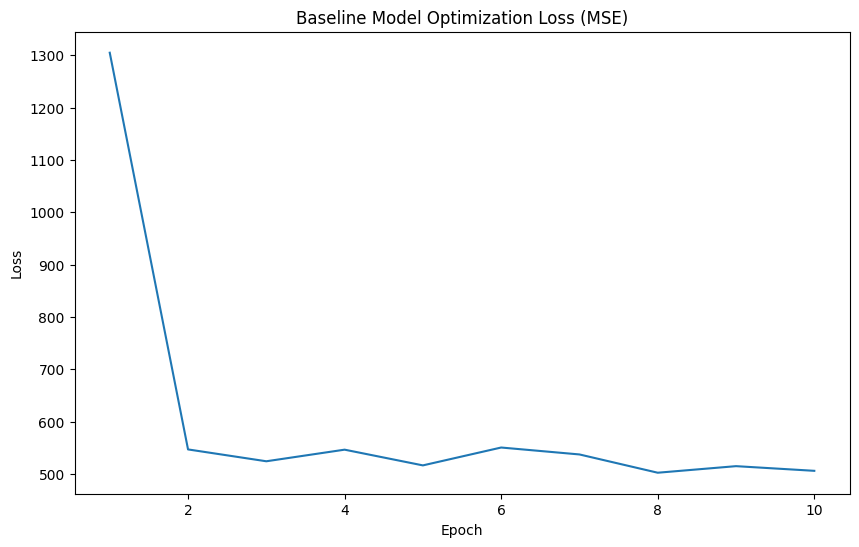

In [16]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(1, eps, num=eps), baseline_model_history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Baseline Model Optimization Loss (MSE)')
plt.show()

## Evaluation

A visual comparison of the original and ground truth images with the predicted images



2/2 ━━━━━━━━━━━━━━━━━━━━ 50s 17s/step


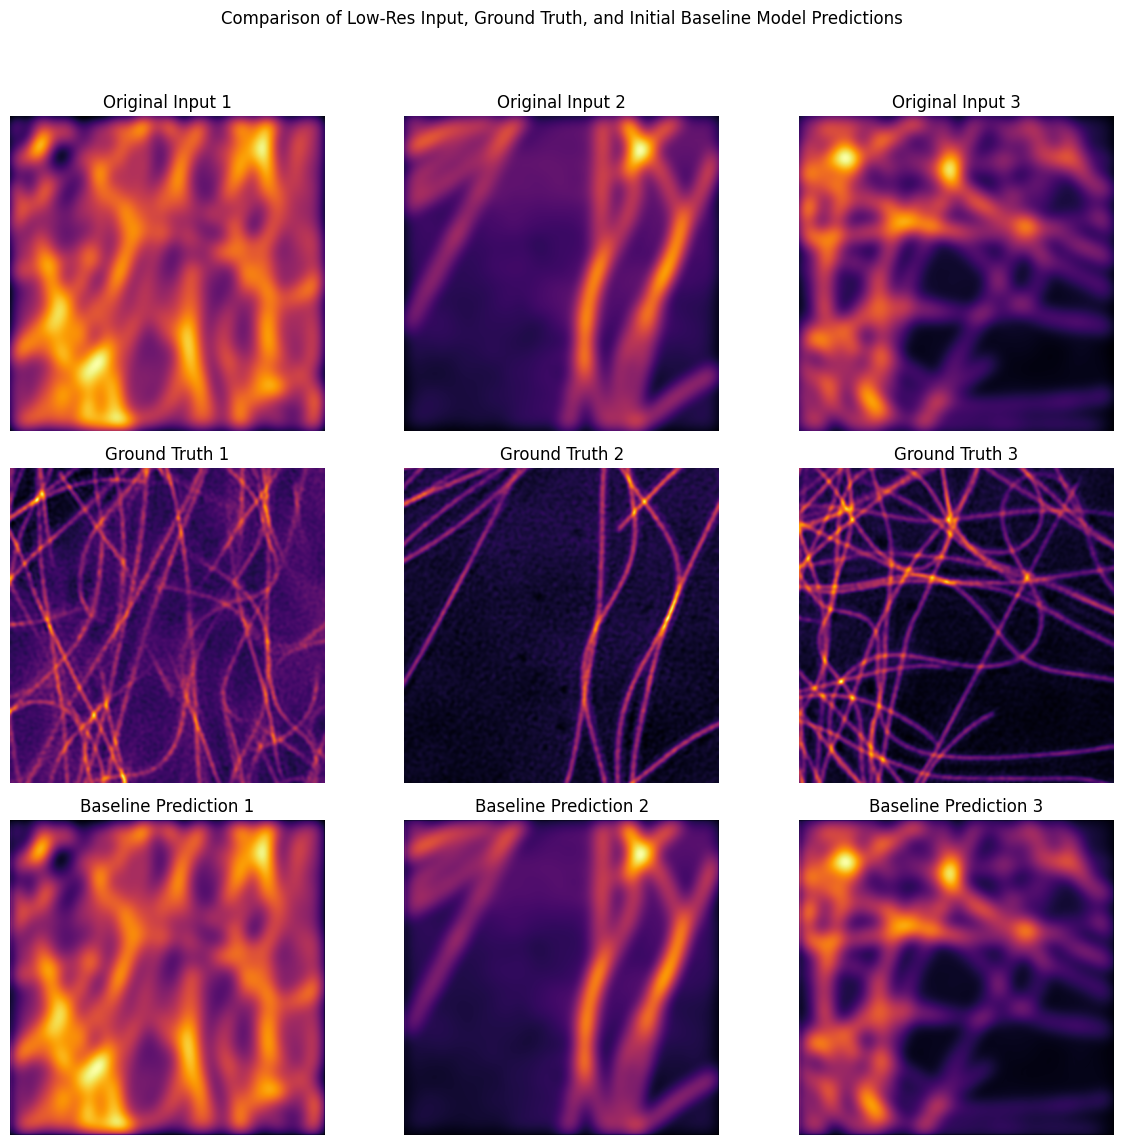

In [17]:
#Evaluatiuon of predicted images of baseline model

predicted_baseline = baseline_cnn_model.predict(x_baseline)

num_examples_to_show_baseline = 3 # Number of examples to visualize

plt.figure(figsize=(num_examples_to_show_baseline * 4, 12))
for i in range(num_examples_to_show_baseline):
    # Original Low-Resolution Input
    plt.subplot(3, num_examples_to_show_baseline, i + 1)
    plt.imshow(x_baseline[i, :, :, 0], cmap='inferno')
    plt.title(f'Original Input {i+1}')
    plt.axis('off')

    # Ground Truth
    plt.subplot(3, num_examples_to_show_baseline, i + 1 + num_examples_to_show_baseline)
    plt.imshow(y_baseline[i, :, :, 0], cmap='inferno')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')

    # Model Prediction
    plt.subplot(3, num_examples_to_show_baseline, i + 1 + 2 * num_examples_to_show_baseline)
    plt.imshow(predicted_baseline[i, :, :, 0], cmap='inferno')
    plt.title(f'Baseline Prediction {i+1}')
    plt.axis('off')

plt.suptitle('Comparison of Low-Res Input, Ground Truth, and Initial Baseline Model Predictions')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
plt.show()
